In [1]:
import sys
sys.path.append('..')

from src.utils.model import *

In [24]:
results_root='../results_n'
save_root = '../riya_figs_n'
data_id = "permutation"

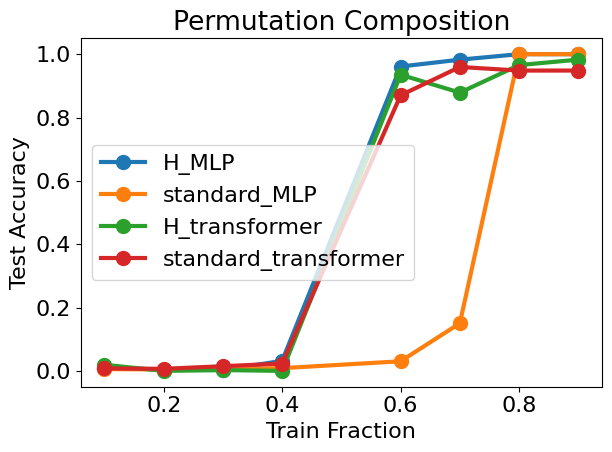

In [28]:
data_id_choices = ["lattice", "greater", "family_tree", "equivalence", "circle", "permutation"]
model_id_choices = ["H_MLP", "standard_MLP", "H_transformer", "standard_transformer"]

import json
import matplotlib.pyplot as plt

seed = 66
# data_id = "lattice"
data_size = 1000
train_ratio = 0.8

data_size_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

results_root = 'results_n'

# for model_id in model_id_choices:
#     metric_list = []
#     for data_size in data_size_list:
#         fname = f'../{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}.json'
#         with open(fname, 'r') as file:
#             data = json.load(file)
#             metric_list.append(data['metric'])
#             if data_size == 1000:
#                 print(model_id, data['variances'][0] + data['variances'][1])
#         fname = f'../{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
#         with open(fname, 'r') as file:
#             data = json.load(file)
# #            metric_list.append(data['test_accuracies'][-1])
#     plt.plot(data_size_list, metric_list, '-o', label=model_id)

# plt.legend()
import numpy as np
plt.rcParams.update({'font.size': 16})
train_ratio_list = np.arange(1, 10) / 10
train_ratio_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]
data_size = 1000

for model_id in model_id_choices:
    metric_list = []
    for train_ratio in train_ratio_list:
        fname = f'../{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}.json'
        with open(fname, 'r') as file:
            data = json.load(file)
#            metric_list.append(data['metric'])
        fname = f'../{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
        with open(fname, 'r') as file:
            data = json.load(file)
            metric_list.append(data['test_accuracies'][-1])

    plt.plot(train_ratio_list, metric_list, '-o', label=model_id,linewidth=3,markersize=10)

plt.legend()
plt.xlabel('Train Fraction')
plt.ylabel('Test Accuracy')

data_id_to_title = {
    "lattice": "In-context Learning",
    "greater": "Greater",
    "family_tree": "Genealogy Learning",
    "equivalence": "Equivalence Classes",
    "circle": "Modular Addition",
    "permutation": "Permutation Composition"
}
plt.title(data_id_to_title[data_id])
plt.tight_layout() 
plt.savefig(f"{save_root}/fig_eff.png",bbox_inches='tight')


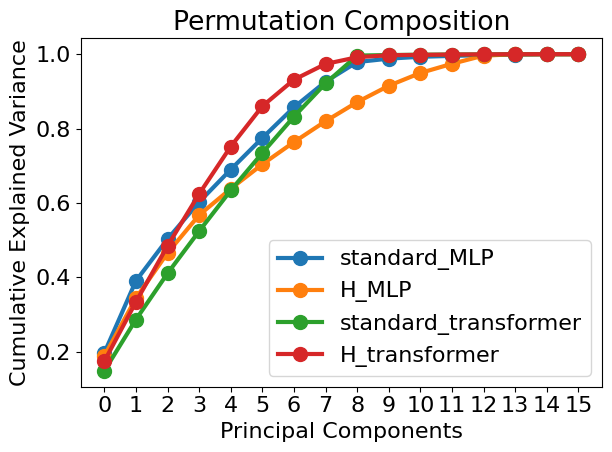

In [23]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 16})
seed=66
train_ratio = 0.8
data_size = 1000
embd_dim = 16

for model_id in model_id_choices:
    fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}.json'
    try:
        with open(fname, 'r') as file:
            data = json.load(file)
            metric_list = data['variances']
    except FileNotFoundError: # Riya: I trained some models without using run_exp.py so did not save variances in .json
        model = load_model_from_file(model_id, data_id, data_size=data_size, train_ratio=train_ratio, seed=seed)
        embd = model.embedding.cpu().detach().numpy() if 'MLP' in model_id else model.embedding.weight.cpu().detach().numpy()
        X = embd
        pca = PCA(n_components=embd_dim) 
        pca.fit(X)
        embd_t = pca.fit_transform(X)
        metric_list = pca.explained_variance_ratio_

    plt.plot(range(16), np.cumsum(np.array(metric_list))[:16], '-o', label=model_id,linewidth=3,markersize=10)

plt.legend()
plt.xticks(range(16))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')

data_id_to_title = {
    "lattice": "In-context Learning",
    "greater": "Greater",
    "family_tree": "Genealogy Learning",
    "equivalence": "Equivalence Classes",
    "circle": "Modular Addition",
    "permutation": "Permutation Composition"
}
plt.title(data_id_to_title[data_id])
plt.tight_layout()
plt.savefig(f"{save_root}/fig_fvu.png",bbox_inches='tight')

In [ ]:
import torch
import matplotlib.pyplot as plt

seed = 66
plt.figure(figsize=(10, 6))
for model_id in ["H_MLP", "standard_MLP"]:

    data_size = 1000
    train_ratio = 0.8

    # Load the .pt file
    weights = torch.load(f"../results/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}.pt")

    # Check the structure of the file (if necessary)
    print(type(weights))
    if isinstance(weights, dict):
        print(weights.keys())  # See the keys in the dictionary

    # Collect all weights into a list
    all_weights = []

    for key, value in weights.items():
        if 'dist' not in key and isinstance(value, torch.Tensor):  # Ensure it's a tensor
            all_weights.extend(value.flatten().tolist())

    # Plot histogram
    
    plt.hist(all_weights, range=(-3,3),bins=100, edgecolor='k', alpha=0.7, label=model_id)
plt.title("Histogram of All Layer Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seed_list = np.linspace(0, 1000, 20, dtype=int)[:4]
model_id = "standard_transformer"
train_acc_list = []
test_acc_list = []
for seed in seed_list:
    fname = f'../results/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
    with open(fname, 'r') as file:
        data = json.load(file)
        train_acc_list.append(data['train_accuracies'])
        test_acc_list.append(data['test_accuracies'])
        print(train_acc_list[-1][-1], test_acc_list[-1][-1])

train_acc_list = torch.tensor(train_acc_list)
test_acc_list = torch.tensor(test_acc_list)

print(train_acc_list.shape, test_acc_list.shape)

plt.figure(figsize=(10, 6))
plt.errorbar(range(train_acc_list.shape[1]), torch.mean(train_acc_list, dim=0), torch.std(train_acc_list, dim=0), label='Train')
#plt.errorbar(range(test_acc_list.shape[1]), torch.mean(test_acc_list, dim=0), torch.std(test_acc_list, dim=0), label='Test')
#plt.xlim(0,20)
plt.legend()

torch.Size([20, 7000]) torch.Size([20, 7000])


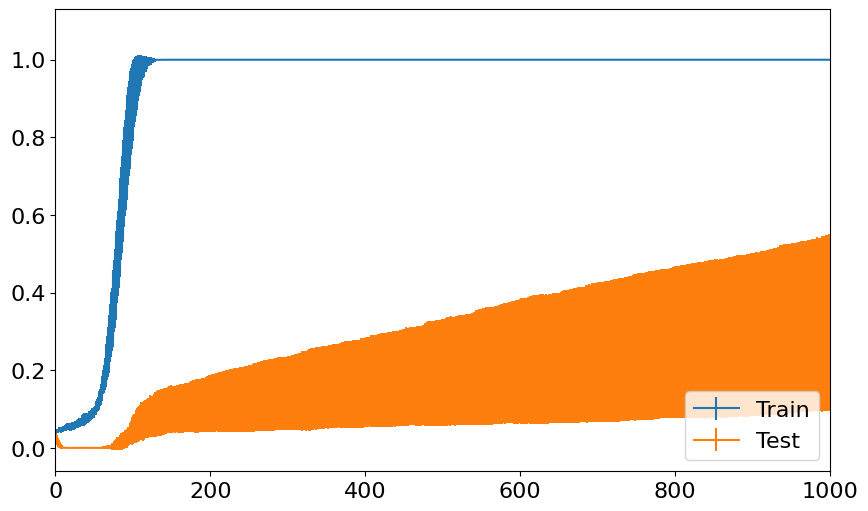

In [22]:
seed_list = np.linspace(0, 1000, 20, dtype=int)
model_id = "standard_MLP"
train_acc_list = []
test_acc_list = []
for seed in seed_list:
    fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
    with open(fname, 'r') as file:
        data = json.load(file)
        train_acc_list.append(data['train_accuracies'])
        test_acc_list.append(data['test_accuracies'])

train_acc_list = torch.tensor(train_acc_list)
test_acc_list = torch.tensor(test_acc_list)

print(train_acc_list.shape, test_acc_list.shape)

plt.figure(figsize=(10, 6))
plt.errorbar(range(train_acc_list.shape[1]), torch.mean(train_acc_list, dim=0), torch.std(train_acc_list, dim=0), label='Train')
plt.errorbar(range(test_acc_list.shape[1]), torch.mean(test_acc_list, dim=0), torch.std(test_acc_list, dim=0), label='Test')
plt.xlim(0,1000)
plt.legend()

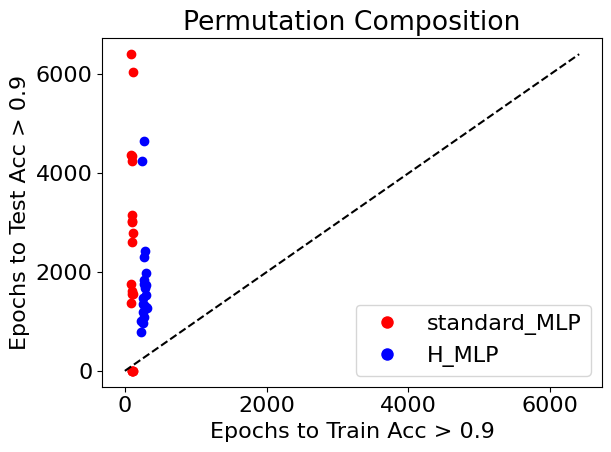

In [ ]:
seed_list = np.linspace(0, 1000, 20, dtype=int)
thres = 0.9
train_ratio = 0.8
train_acc_list = []
test_acc_list = []

max_idx = 0
model_id = "standard_MLP"
model_1 = model_id
for seed in seed_list:
    fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
    with open(fname, 'r') as file:
        try:
            data = json.load(file)
            train_acc_list.append(data['train_accuracies'])
            test_acc_list.append(data['test_accuracies'])
            idx_train = np.argmax(np.array(data['train_accuracies']) > thres)
            idx_test = np.argmax(np.array(data['test_accuracies']) > thres)
            if idx_train > max_idx:
                max_idx = idx_train
            if idx_test > max_idx:
                max_idx = idx_test
            plt.scatter([idx_train], [idx_test], c='r')
        except ValueError:
            continue


train_acc_list = []
test_acc_list = []
model_id = "H_MLP"
model_2 = model_id
for seed in seed_list:
    fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_train_results.json'
    with open(fname, 'r') as file:
        data = json.load(file)
        train_acc_list.append(data['train_accuracies'])
        test_acc_list.append(data['test_accuracies'])
        idx_train = np.argmax(np.array(data['train_accuracies']) > thres)
        idx_test = np.argmax(np.array(data['test_accuracies']) > thres)
        plt.scatter(idx_train, idx_test, c='b')
        if idx_train > max_idx:
            max_idx = idx_train
        if idx_test > max_idx:
            max_idx = idx_test

plt.plot(range(max_idx+1), range(max_idx+1), 'k--')
plt.xlabel('Epochs to Train Acc > {}'.format(thres))
plt.ylabel('Epochs to Test Acc > {}'.format(thres))

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=model_1, markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label=model_2, markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_handles)
data_id_to_title = {
    "lattice": "In-context Learning",
    "greater": "Greater",
    "family_tree": "Genealogy Learning",
    "equivalence": "Equivalence Classes",
    "circle": "Modular Addition",
    "permutation": "Permutation Composition"
}
plt.title(data_id_to_title[data_id])
plt.tight_layout()
plt.savefig(f"{save_root}/fig_grok_mlp.png",bbox_inches='tight')

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

# Create a 16x20 grid of subplots
fig, axes = plt.subplots(16, 20, figsize=(20, 16))

data_id_choices = ["lattice", "family_tree", "equivalence", "circle", "permutation"]
model_id_choices = ["standard_MLP","H_MLP", "standard_transformer","H_transformer"]

colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']

seed_list = np.linspace(0, 1000, 20, dtype=int)

dict_level = dict()
dict_level[1] = 0
for i in range(1,127):
    if (2*i) < 127:
        dict_level[2*i] = dict_level[i] + 1
    if (2*i + 1) < 127:
        dict_level[2*i + 1] = dict_level[i] + 1

# Add labels for rows and columns
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        
        # Remove ticks for clarity
        ax.set_xticks([])
        ax.set_yticks([])

        data_id = data_id_choices[i // 4]
        model_id = model_id_choices[i % 4]
        seed = seed_list[j]

        weights = torch.load(f"{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}.pt")
        if 'MLP' in model_id:
            emb = weights['embedding']
        else:
            emb = weights['embedding.weight']

        if "family" in data_id:
            emb = emb[1:127]

        pca = PCA(n_components=2)
        pca_emb = pca.fit_transform(emb.cpu())
        if i != 0:
            ax.set_title(f'EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100: .0f}%',fontsize=8)
        else:
            ax.set_xlabel(f'EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100: .0f}%',fontsize=8)
            ax.xaxis.set_label_position('top')

        if "family" in data_id:
            for kk in range(1,127):
                ax.scatter(pca_emb[kk-1, 0], pca_emb[kk-1, 1], c=colors[dict_level[kk]])
        else:
            ax.scatter(pca_emb[:, 0], pca_emb[:, 1])
        
        
        # Label the first column with row numbers
        if j == 0:
            ax.set_ylabel(f'{data_id}\n{model_id}', rotation=0, labelpad=30, fontsize=8, ha='right', va='center')
        
        # Label the last row with column numbers
        if i == 0:
            ax.set_title(f'Seed {seed}', fontsize=8)
#            ax.xaxis.set_label_position('top')  # Place column labels at the top

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\u admin\AppData\Local\Temp\ipykernel_11492\1489103273.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{results_root}/{seed}_{data_id}_{m

FileNotFoundError: [Errno 2] No such file or directory: '../results_n/0_lattice_standard_MLP_1000_0.8.pt'

Error in callback <function flush_figures at 0x00000250C7A8BF60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 